This file contains the original ResNet18 trained on the flowers102 dataset. 

We froze the ResNet18 architecture, and we trained the network on the flowers102 dataset to learn the weights for the last layer of fully connected layer. 

We used this model's performance to show the difference between the frozen and unfrozen models. 

The required python packages will be installed by running the cell below this. 

The code is written such that it needs to be run on GPU. 

In [1]:
!pip install torch
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install pillow
!pip install scipy
!pip install torchvision
!pip install shutil
!pip install pylab

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for shutil



Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement pylab (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for pylab


In [2]:
import pylab
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import scipy
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory

Here, we are downloading the dataset and storing it into a `./train` folder. We applied the following transformations in the `data_transforms` dictionary. 

In [3]:
data_dir = './'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print(f"Downloading Training dataset:")
train_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='train', transform=data_transforms['train'], download=True)

print(f"Downloading Validation dataset:")
val_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='val', transform=data_transforms['val'], download=True)

print(f"Downloading Test dataset:")
test_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='test', transform=data_transforms['test'], download=True)

100%|██████████| 344862509/344862509 [02:54<00:00, 1977848.59it/s]


Extracting train\flowers-102\102flowers.tgz to train\flowers-102


100%|██████████| 502/502 [00:00<?, ?it/s]


100%|██████████| 14989/14989 [00:00<?, ?it/s]

Here, we load the folders into dataloaders of `train`, `val`, `test`. The batch size is initialized as 4. 

In [4]:
datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

# print(f"{len(train_dataset._labels)}")
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train'].classes

print(f"dataloaders: {dataloaders}")
print(f"Dataset sizes: {dataset_sizes}")


dataloaders: {'train': <torch.utils.data.dataloader.DataLoader object at 0x00000247058DB350>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x000002470543EDE0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x00000247058DB6B0>}
Dataset sizes: {'train': 1020, 'val': 1020, 'test': 6149}


In [5]:
print(f"dataloader train length: {len(dataloaders['train'].dataset)}")

dataloader train length: 1020


In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

The function below is to train the model. 

In [7]:
import torch
import time
import os

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    
    # Save initial model parameters to restore later if needed
    best_model_params = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the selected device
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_params = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_params)
    return model, train_loss, train_acc, val_loss, val_acc

Here, we load the ResNet18 model into the variable `model`. We then convert the last fully connected layer to an output of 102 neurons. 
We added a line to set `requires_grad = False` so that the model weights will be frozen. 
We load the model to the device. 

We used Cross Entropy Loss for the cost function, an SGD optimizer and a learning rate scheduler. However, the learning rate scheduler's step size is set at 200 to allow the model to learn as much as possible. 

In [8]:
model_path = './model_checkpoints/resnet18_original_params.pt'

check_file = os.path.exists(model_path)
if check_file:
    print(f"Loading model from checkpoint")
    model = torch.load(model_path)
else:
    print(f"Model checkpoint does not exist.\nDownloading new model...")
    model = models.resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=200, gamma=0.1)

Model checkpoint does not exist.
Device: cuda:0


Displaying the model architecture. 

In [9]:
for key, val in model.state_dict().items():
    if "mean" in key or "var" in key or "tracked" in key:
        continue
    print(f"{key} : {val.cpu().detach().numpy().shape}")

conv1.weight : (64, 3, 7, 7)
bn1.weight : (64,)
bn1.bias : (64,)
layer1.0.conv1.weight : (64, 64, 3, 3)
layer1.0.bn1.weight : (64,)
layer1.0.bn1.bias : (64,)
layer1.0.conv2.weight : (64, 64, 3, 3)
layer1.0.bn2.weight : (64,)
layer1.0.bn2.bias : (64,)
layer1.1.conv1.weight : (64, 64, 3, 3)
layer1.1.bn1.weight : (64,)
layer1.1.bn1.bias : (64,)
layer1.1.conv2.weight : (64, 64, 3, 3)
layer1.1.bn2.weight : (64,)
layer1.1.bn2.bias : (64,)
layer2.0.conv1.weight : (128, 64, 3, 3)
layer2.0.bn1.weight : (128,)
layer2.0.bn1.bias : (128,)
layer2.0.conv2.weight : (128, 128, 3, 3)
layer2.0.bn2.weight : (128,)
layer2.0.bn2.bias : (128,)
layer2.0.downsample.0.weight : (128, 64, 1, 1)
layer2.0.downsample.1.weight : (128,)
layer2.0.downsample.1.bias : (128,)
layer2.1.conv1.weight : (128, 128, 3, 3)
layer2.1.bn1.weight : (128,)
layer2.1.bn1.bias : (128,)
layer2.1.conv2.weight : (128, 128, 3, 3)
layer2.1.bn2.weight : (128,)
layer2.1.bn2.bias : (128,)
layer3.0.conv1.weight : (256, 128, 3, 3)
layer3.0.bn1.w

Model training starts here.

We used 100 epochs.

In [10]:
no_epochs = 100

model, train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=no_epochs)

Epoch 0/99
----------
train Loss: 4.7004 Acc: 0.0225
val Loss: 4.0429 Acc: 0.0931

Epoch 1/99
----------
train Loss: 4.0589 Acc: 0.1127
val Loss: 3.1513 Acc: 0.3598

Epoch 2/99
----------
train Loss: 3.5463 Acc: 0.2314
val Loss: 2.4661 Acc: 0.4922

Epoch 3/99
----------
train Loss: 3.1433 Acc: 0.3294
val Loss: 2.0609 Acc: 0.5931

Epoch 4/99
----------
train Loss: 2.7920 Acc: 0.4265
val Loss: 1.8005 Acc: 0.6167

Epoch 5/99
----------
train Loss: 2.4638 Acc: 0.5088
val Loss: 1.5560 Acc: 0.6735

Epoch 6/99
----------
train Loss: 2.2254 Acc: 0.5569
val Loss: 1.4191 Acc: 0.7020

Epoch 7/99
----------
train Loss: 2.0436 Acc: 0.6127
val Loss: 1.2466 Acc: 0.7255

Epoch 8/99
----------
train Loss: 1.8526 Acc: 0.6343
val Loss: 1.1095 Acc: 0.7627

Epoch 9/99
----------
train Loss: 1.7123 Acc: 0.6922
val Loss: 1.0136 Acc: 0.7931

Epoch 10/99
----------
train Loss: 1.6357 Acc: 0.6735
val Loss: 0.9941 Acc: 0.7657

Epoch 11/99
----------
train Loss: 1.5922 Acc: 0.6990
val Loss: 0.8960 Acc: 0.7902

Ep

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # Changed classes to labels so it corresponds to the labels from dataloader['val']
                ax.set_title(f'Predicted: {preds[j]} | True: {labels[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Here, we can see that the model got 5/6 predictions correct as a sample visualization. 

The model's best validation accuracy is at 87.55%. It is slightly lower than the ResNet18 model that had unfrozen parameters. 

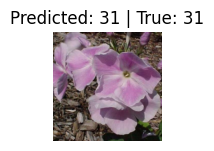

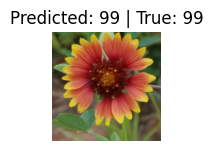

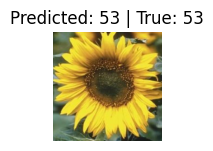

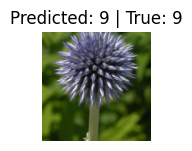

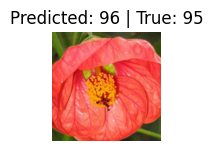

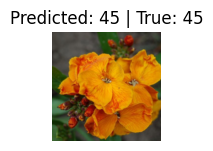

In [12]:
visualize_model(model)

In [13]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

This is the plotting for epoch vs accuracy and epoch vs loss. 

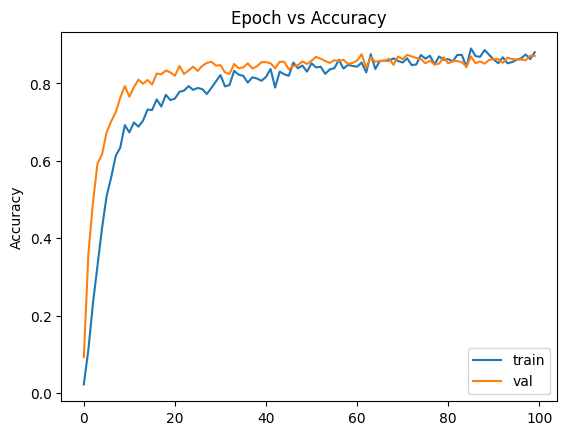

In [14]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i].cpu()

for i in range(len(val_acc)):
    val_acc[i] = val_acc[i].cpu()
    
plot_graph(no_epochs, train_acc, val_acc, "Epoch vs Accuracy")

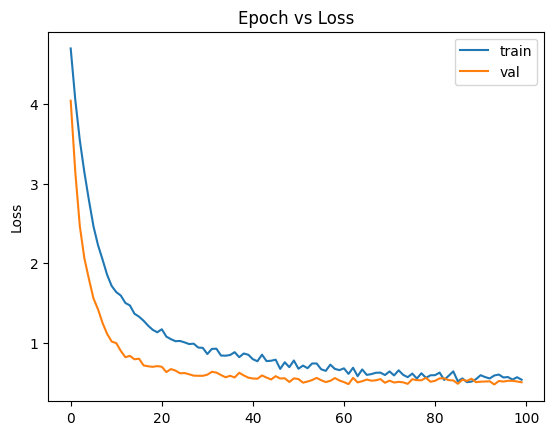

In [15]:
plot_graph(no_epochs, train_loss, val_loss, "Epoch vs Loss")

This is the function to test the model.

In [16]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    test_loss, correct = 0, 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            if i % 20 == 0:
                print(f'Predicted: {preds[0]} | True: {labels[0]}')
                
    test_loss /= size
    correct = correct.double() / size
    model.train(mode=was_training)
    return test_loss, correct

In [17]:
test_loss, test_acc = test(model)
print(f'Test Loss:\t{test_loss:.4f}\tTest Acc:\t{test_acc:.4f}')


Predicted: 8 | True: 2
Predicted: 40 | True: 40
Predicted: 75 | True: 50
Predicted: 11 | True: 11
Predicted: 77 | True: 77
Predicted: 72 | True: 72
Predicted: 22 | True: 22
Predicted: 100 | True: 100
Predicted: 36 | True: 36
Predicted: 17 | True: 17
Predicted: 100 | True: 10
Predicted: 41 | True: 88
Predicted: 87 | True: 87
Predicted: 40 | True: 40
Predicted: 28 | True: 50
Predicted: 61 | True: 61
Predicted: 15 | True: 73
Predicted: 72 | True: 72
Predicted: 37 | True: 37
Predicted: 9 | True: 9
Predicted: 91 | True: 91
Predicted: 47 | True: 47
Predicted: 88 | True: 89
Predicted: 72 | True: 72
Predicted: 27 | True: 27
Predicted: 72 | True: 77
Predicted: 45 | True: 45
Predicted: 71 | True: 29
Predicted: 93 | True: 93
Predicted: 94 | True: 94
Predicted: 63 | True: 74
Predicted: 45 | True: 45
Predicted: 28 | True: 28
Predicted: 73 | True: 73
Predicted: 59 | True: 59
Predicted: 21 | True: 21
Predicted: 49 | True: 49
Predicted: 72 | True: 72
Predicted: 75 | True: 75
Predicted: 22 | True: 22
P

Here, we tested the model on the test dataset. The model had an accuracy of 84.94%.

Printing the model architecture here.

In [18]:
print(f"{model}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  